In this notebook, we replicate some previous network coordination detection algorithms using coURLs. We generate networks graphs for each engagement type and then compute node centralities using eigenvalues. We then build cdf plots to determine a threshold value for coordinated activity. Finally, we do some basic qualitative analysis to better understand idealogies, opinions, etc.

In [1]:
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import networkx as nx
from datetime import datetime
from datetime import timedelta

In [4]:
import scipy
import sklearn

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity 

In [6]:
gaza_data = pd.read_csv("~/Downloads/gaza_data/challenge_problem_two_21NOV.csv")

In [7]:
gaza_data.tweet_type.unique()

array(['retweet', 'tweet', 'reply', 'quote'], dtype=object)

In [ ]:
# 'twitterAuthorScreenname', 'engagementType', 'engagementParentId', tweet_text, tweetid

In [8]:
# twitterAuthorScreenname --> screen_name
# engagementType --> tweet_type 
# engagementParentId --> linked_tweet 
# tweet_text --> text 
# tweetid --> id 
gaza_data.columns

Index(['created_at', 'follower_count', 'following_count', 'id', 'imageUrls',
       'lang', 'like_count', 'linked_tweet', 'retweet_count', 'screen_name',
       'text', 'tweet_type', 'urls'],
      dtype='object')

In [9]:
# retrieves tweet's timestamp from its ID
def get_tweet_timestamp(tid):
    try:
        offset = 1288834974657
        tstamp = (tid >> 22) + offset
        utcdttime = datetime.utcfromtimestamp(tstamp/1000)
        return utcdttime
    except:
        return None

In [69]:
def hashSeq(dataset, minHashtags = 4):
    dataset['engagementParentId'] = dataset['linked_tweet']
    dataset['twitterAuthorScreenname'] = dataset['screen_name']
    dataset['engagementType'] = dataset['tweet_type']
    dataset['tweet_text'] = dataset['text']
    dataset['tweetId'] = dataset['id']
    
    dataset['tweet_timestamp'] = dataset['tweetId'].apply(lambda x: get_tweet_timestamp(x))
    
    above_threshold_name = ['dradnanuog', 'arslan_ranjha47', 'Ymer77', 'kh_deeplines41', 'fluffyysamoyed', 'TehseenAnwar5', 'SardarkhanIk', 'Babypink127', 'ZohaibA78374994', 'ahad465', 'aglutinacao', 'Cynthia94015264', 'NaveedBhatti222', 'txjhty', 'VH_Khalida', 'tssadya', 'waiswap', 'soleymaniehfini', 'adrian_currie', 'Campaignforjus1', 'GOP82279608', 'AirtonA22031392', 'dalerapley', 'Aniavazzo28', 'Annpae', 'juball15', 'PurkeyLinda', 'haechanwinxx']
    
    cum = dataset.loc[dataset['engagementType'] != 'retweet']
    cum['hashtag_seq'] = ['__'.join([tag.strip("#") for tag in tweet.split() if tag.startswith("#")]) for tweet in cum['tweet_text'].values.astype(str)]
    cum.drop('tweet_text', axis=1, inplace=True)
    cum = cum[['twitterAuthorScreenname', 'hashtag_seq']].loc[cum['hashtag_seq'].apply(lambda x: len(x.split('__'))) >= minHashtags]
    
    cum.drop_duplicates(inplace=True)
    
    temp = cum.groupby('hashtag_seq', as_index=False).count()
    cum = cum.loc[cum['hashtag_seq'].isin(temp.loc[temp['twitterAuthorScreenname']>1]['hashtag_seq'].to_list())]

    cum['value'] = 1
    
    print(cum[cum['twitterAuthorScreenname'].isin(above_threshold_name)].groupby(['hashtag_seq']).size().reset_index(name='count').sort_values(by=['count'], ascending=False).head().values)
    
    hashs = dict(zip(list(cum.hashtag_seq.unique()), list(range(cum.hashtag_seq.unique().shape[0]))))
    cum['hashtag_seq'] = cum['hashtag_seq'].apply(lambda x: hashs[x]).astype(int)
    del hashs

    userid = dict(zip(list(cum.twitterAuthorScreenname.astype(str).unique()), list(range(cum.twitterAuthorScreenname.unique().shape[0]))))
    cum['twitterAuthorScreenname'] = cum['twitterAuthorScreenname'].astype(str).apply(lambda x: userid[x]).astype(int)
    
    person_c = pd.CategoricalDtype(sorted(cum.twitterAuthorScreenname.unique()), ordered=True)
    thing_c = pd.CategoricalDtype(sorted(cum.hashtag_seq.unique()), ordered=True)
    
    row = cum.twitterAuthorScreenname.astype(person_c).cat.codes
    col = cum.hashtag_seq.astype(thing_c).cat.codes
    sparse_matrix = scipy.sparse.csr_matrix((cum["value"], (row, col)), shape=(person_c.categories.size, thing_c.categories.size))
    del row, col, person_c, thing_c

    #cum = pd.pivot_table(cum,'value', 'userid', 'urls', aggfunc='max')
    #cum.fillna(0, inplace = True)
    
    vectorizer = TfidfTransformer()
    tfidf_matrix = vectorizer.fit_transform(sparse_matrix)
    similarities = cosine_similarity(tfidf_matrix, dense_output=False)


    df_adj = pd.DataFrame(similarities.toarray())
    del similarities
    df_adj.index = userid.keys()
    df_adj.columns = userid.keys()
    G = nx.from_pandas_adjacency(df_adj)
    del df_adj
    
    G.remove_edges_from(nx.selfloop_edges(G))
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

In [70]:
G = hashSeq(gaza_data)

[['Palestine__Israel.__Gaza__ShieldTheChildren' 14]
 ['StopGenocideInGaza__CeaseFireInGaza__CeaseFireNOW__FreePalestine' 6]
 ['طوفان_الأقصى__طوفان_القدس__فلسطین__حماس__طوفان_الاقصى__Palestine__Palestinian__Israel__Hamas__TelAviv__Gaza__GazaUnderAttack__OperationAlAqsaFlood'
  2]
 ['Israel__Gaza__IsraelPalestineWar__Hamas__طوفان_الأقصى__IsraelAtWar__طوفان_القدس__GazaUnderAttack'
  2]
 ['israel__hamas__Palestine__اسرائیل__حماس__فلسطين__طوفان_الأقصى' 2]]


In [43]:
centrality = nx.eigenvector_centrality_numpy(G)
values = [v for k, v in centrality.items()]
idxs = np.argsort(values)
users = [k for k, v in centrality.items()]
values.sort()
values.reverse()
values[:5]

[0.07457782232771279,
 0.07347278926823707,
 0.07253753414338121,
 0.07238282230435975,
 0.07200866358955824]

In [44]:
sorted_users = [users[i] for i in idxs]
sorted_users.reverse()
sorted_users[:5]

['RaghdaOthm3746',
 'FreePalstine710',
 'soomah59',
 'bro_ahmed73',
 'AlbustanjiEnas']

In [45]:
len(values)

5435

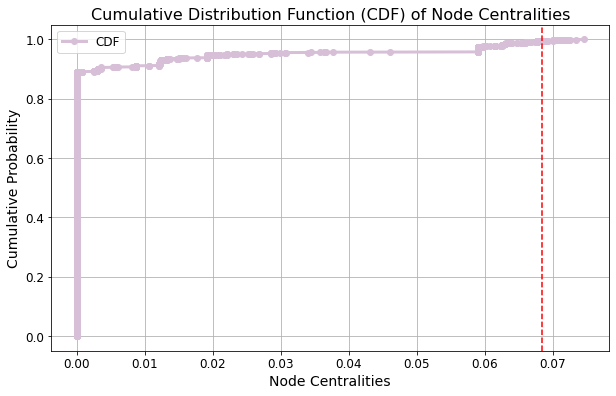

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Your node centralities
centralities = values # Include the full list

# Sort the centralities
sorted_centralities = np.sort(centralities)

# Calculate the cumulative distribution function (CDF)
cdf = np.arange(1, len(sorted_centralities) + 1) / len(sorted_centralities)

# Create a larger and nicer figure
plt.figure(figsize=(10, 6))

# Create the CDF plot with a thicker line in a lighter purple color
plt.plot(sorted_centralities, cdf, label='CDF', linewidth=3, marker='o', color='#d8bfd8', linestyle='-')

# Add labels and title with increased font size
plt.xlabel('Node Centralities', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.title('Cumulative Distribution Function (CDF) of Node Centralities', fontsize=16)

# Set grid, legend, and adjust tick font size
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a vertical line when CDF reaches 0.7
threshold_cdf = 0.995
threshold_index = np.argmax(cdf >= threshold_cdf)
threshold_centrality = sorted_centralities[threshold_index]
plt.axvline(threshold_centrality, color='red', linestyle='--', label=f'CDF = {threshold_cdf}')


# Show the plot
plt.show()


In [47]:
def nodes_above_cdf_threshold(centralities, node_names, cdf_threshold):
    """
    Returns a list of node names whose cumulative density values are above the given threshold.

    Parameters:
    - centralities (list): List of node centralities.
    - node_names (list): List of corresponding node names.
    - cdf_threshold (float): Cumulative density threshold value.

    Returns:
    - list: Nodes with cumulative density values above the threshold.
    """
    sorted_indices = np.argsort(centralities)
    sorted_cdf = np.cumsum(np.ones_like(centralities)) / len(centralities)
#     print(sorted_cdf)
    above_threshold_nodes = [node_names[i] for i in sorted_indices if sorted_cdf[i] > cdf_threshold]
    return above_threshold_nodes

# Example usage:
centralities = values
node_names = sorted_users
cdf_threshold_value = 0.995

above_cdf_threshold_nodes = nodes_above_cdf_threshold(centralities, node_names, cdf_threshold_value)
print(f"Nodes with cumulative density values above {cdf_threshold_value}: {above_cdf_threshold_nodes}")


Nodes with cumulative density values above 0.995: ['dradnanuog', 'arslan_ranjha47', 'Ymer77', 'kh_deeplines41', 'fluffyysamoyed', 'TehseenAnwar5', 'SardarkhanIk', 'Babypink127', 'ZohaibA78374994', 'ahad465', 'aglutinacao', 'Cynthia94015264', 'NaveedBhatti222', 'txjhty', 'VH_Khalida', 'tssadya', 'waiswap', 'soleymaniehfini', 'adrian_currie', 'Campaignforjus1', 'GOP82279608', 'AirtonA22031392', 'dalerapley', 'Aniavazzo28', 'Annpae', 'juball15', 'PurkeyLinda', 'haechanwinxx']


Graph with 28 nodes and 109 edges


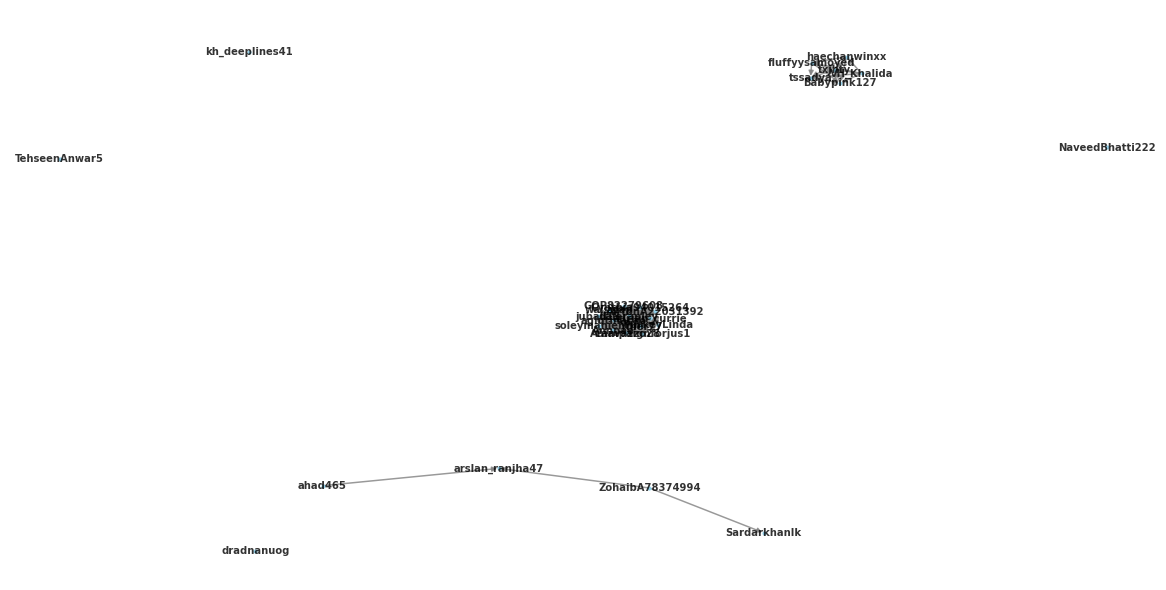

In [57]:
# users 0.9 threshold
subgraph = G.subgraph(above_cdf_threshold_nodes)

# Create a new graph with the subgraph
new_G = nx.Graph(subgraph)
print(new_G)

import matplotlib.pyplot as plt
# Define a layout for the graph (e.g., circular layout)
layout = nx.spring_layout(new_G)

plt.figure(figsize=(16,8)) 


# Draw the graph with labels
nx.draw(new_G, pos=layout, with_labels=True, arrows=True, width=1.5, font_weight='bold', node_size=10, font_size=10, node_color='skyblue', edge_color='gray', linewidths=1, alpha=0.8)

In [54]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[2174,
 606,
 239,
 50,
 41,
 29,
 27,
 25,
 24,
 21,
 19,
 17,
 17,
 15,
 15,
 15,
 15,
 12,
 12,
 12,
 11,
 11,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3

In [61]:
erroll = retweet_data[retweet_data['screen_name'].str.contains('ErrolLync')]
eroll_rt = retweet_data[retweet_data['orig_author_screenname'].str.contains('ErrolLync')]

erroll.groupby(['screen_name', 'orig_author_screenname']).size().reset_index(name='count')

,screen_name,orig_author_screenname,count
0,ErrolLynch10,ErrolLynch10,19
1,ErrolLynch10,ErrolLynch3,10
2,ErrolLynch10,ErrolLynch7,22
3,ErrolLynch10,ErrolLynch76823,32
4,ErrolLynch10,sixsign,8
5,ErrolLynch3,ErrolLynch10,19
6,ErrolLynch3,ErrolLynch3,11
7,ErrolLynch3,ErrolLynch7,20
8,ErrolLynch3,ErrolLynch76823,32
9,ErrolLynch3,sixsign,8


In [62]:
sixsign = retweet_data[retweet_data['screen_name'] == 'sixsign']
sixsign_rt = retweet_data[retweet_data['orig_author_screenname'] == 'sixsign']

In [63]:
sixsign.groupby(['screen_name', 'orig_author_screenname']).size().reset_index(name='count')

,screen_name,orig_author_screenname,count
0,sixsign,ErrolLynch10,19
1,sixsign,ErrolLynch3,11
2,sixsign,ErrolLynch7,22
3,sixsign,ErrolLynch76823,29
4,sixsign,sixsign,8


In [68]:
from collections import Counter
Counter(erroll.text.values).most_common(5)

[('RT @ErrolLynch7 @TeamPelosi @JudiciaryDems @POTUS @VP @SenateDems @NATO @UN @vonderleyen @ABaerbock @EP_President @Israel @ErrolLynch10 @BarackObama @RepAOC @TheJusticeDept @IntlCrimCourt @antonioguterres @SustDev @sixsign @NASASun @Queen_Europe @FedericaMog @EU_Commission @eu_eeas @OHCHRAsia @OHCHR_Europe @UNDP @GermanyUN @UNDPAfrica @UNDPasiapac @UNDPChina @WIPO @EPOorg @UNHumanRights @jensstoltenberg @Assita_Kanko @GabrielMariya @HouseDemocrats @EmmanuelMacron Does #Hamas weapons come from the #US #NATO #Russia or? Only a friend to foe would know how to manipulate @NATO #StandWithUkraine🇺🇦 #StandWithIsrael🇮🇱 @UN @vonderleyen @ABaerbock @EP_President @POTUS @VP @Israel @ErrolLynch10 @BarackObama @RepAOC 7️⃣ https://t.co/OTA6ABAM0P',
  8),
 ('RT @ErrolLynch10 @ErrolLynch76823 @ARD_BaB @ABaerbock @antonioguterres @vonderleyen @GabrielMariya @EP_President @ErrolLynch7 @jensstoltenberg @POTUS @VP @SenateDems @HouseDemocrats @BarackObama @NATO Does #Hamas weapons come from the #US #NAT

In [74]:
sixsign[['orig_author_screenname', 'screen_name', 'text']].values

array([['ErrolLynch10', 'sixsign',
        'RT @ErrolLynch10 @ErrolLynch76823 @ARD_BaB @ABaerbock @antonioguterres @vonderleyen @GabrielMariya @EP_President @ErrolLynch7 @jensstoltenberg @POTUS @VP @SenateDems @HouseDemocrats @BarackObama @NATO Does #Hamas weapons come from the #US #NATO or #Russia? Only a friend to foe would know how to manipulate @NATO to turn forces from: #StandWithUkraine🇺🇦 #StandWithIsrael🇮🇱 @vonderleyen @ABaerbock @EP_President @POTUS @VP @BarackObama @ErrolLynch10 7️⃣ https://t.co/DZLNM3t3Ww'],
       ['ErrolLynch76823', 'sixsign',
        'RT @ErrolLynch76823 @JackFought_1 @antonioguterres @vonderleyen @ABaerbock @GabrielMariya @EP_President @ErrolLynch7 @jensstoltenberg @POTUS @VP @SenateDems @HouseDemocrats @BarackObama @NATO Does #Hamas weapons come from the #US #NATO or #Russia? Only a friend to foe would know how to manipulate @NATO to turn forces from: #StandWithUkraine🇺🇦 #StandWithIsrael🇮🇱 @vonderleyen @ABaerbock @EP_President @POTUS @VP @BarackObama @Er